In [1]:
import sys
sys.path.append("../../XLEMOO")

In [2]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import asf_wrapper, hypervolume_contribution, inside_ranges
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses, plot_mean_fitnesses, plot_std_fitnesses, plot_hypervolume, show_rules
from XLEMOO.selection import SelectNBest
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from desdeo_problem.testproblems import car_side_impact

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier, SlipperClassifier, BoostedRulesClassifier, SkopeRulesClassifier
import imodels

## Define problem

In [149]:
n_objectives = 4
n_variables = 7

problem = car_side_impact(three_obj=False)

In [150]:
problem.evaluate(np.array([[1, 0.9, 1, 1, 1.75, 0.8, 0.8], [1, 0.9, 1, 1, 1.75, 0.8, 0.8]])).constraints.sum(axis=1)

array([9.29749578, 9.29749578])

## Setting model parameters

In [182]:
"""
nadir = np.ones(n_objectives)
ideal = np.zeros(n_objectives)
# ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
# nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
#ref_point = np.array([-5.0, -3.1, -4.4, 4.2, 0.15])
#guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = lambda x: guess_asf(x) + stom_asf(x) + np.random.uniform(0, 1)

# lower_limits = np.array([-5.5, -3.2, -5.4, 3.2, 0.05])
# upper_limits = np.array([-3.9, -2.9, -0.9, 7.2, 0.20])

lower_limits = np.array([0.4, 0.4, 0.6])
upper_limits = np.array([0.5, 0.5, 0.75])
ref_point = (lower_limits + upper_limits) / 2


stom_asf = asf_wrapper(StomASF(ideal=ideal), {"reference_point": ideal})
guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})
ref_asf = asf_wrapper(PointMethodASF(ideal=ideal, nadir=nadir), {"reference_point": ref_point})
hyper_fun = hypervolume_contribution(nadir)
inside_ranges_fun = inside_ranges(lower_limits, upper_limits, sim_cost=0, asf_fun=ref_asf)
"""

nadir = np.array([40.0, 5.0, 14.0, 30.0])
ideal = np.array([15.0, 3.0, 10.0, 0.0])

ref_point = np.array([20.0, 3.5, 11.0, 0.1])

ref_asf = asf_wrapper(PointMethodASF(ideal=ideal, nadir=nadir), {"reference_point": ref_point})

fitness_fun = ref_asf


lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = 0.99999,
    darwin_probe = 5,
    darwin_threshold = 0.99999,
    total_iterations=200
)

ea_params = EAParams(
    population_size=200,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    # selection_op=TournamentSelection(None, tournament_size=3),
    selection_op=SelectNBest(None, 200),
    population_init_design="LHSDesign",
    iterations_per_cycle=10,
)

# ml = DecisionTreeClassifier(random_state=0)
# ml = SlipperClassifier()
# ml = BoostedRulesClassifier()
ml = SkopeRulesClassifier(precision_min=0.1, n_estimators=30, max_features=None, max_depth=None, bootstrap=True, bootstrap_features=True)
ml_params = MLParams(
    H_split=0.10,
    L_split=0.10,
    ml_model=ml,
    instantation_factor=10,
    generation_lookback=0,
    ancestral_recall=0,
    unique_only=True,
    iterations_per_cycle=1,
)

## Setup LEMOO model

In [183]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [185]:
lemoo.run_iterations()

h_gorup shape: (15229, 7)
l_gorup shape: (15229, 7)
.
h_gorup shape: (15293, 7)
l_gorup shape: (15293, 7)
.
h_gorup shape: (15362, 7)
l_gorup shape: (15362, 7)
.
h_gorup shape: (15425, 7)
l_gorup shape: (15425, 7)
.
h_gorup shape: (15495, 7)
l_gorup shape: (15495, 7)


KeyboardInterrupt: 

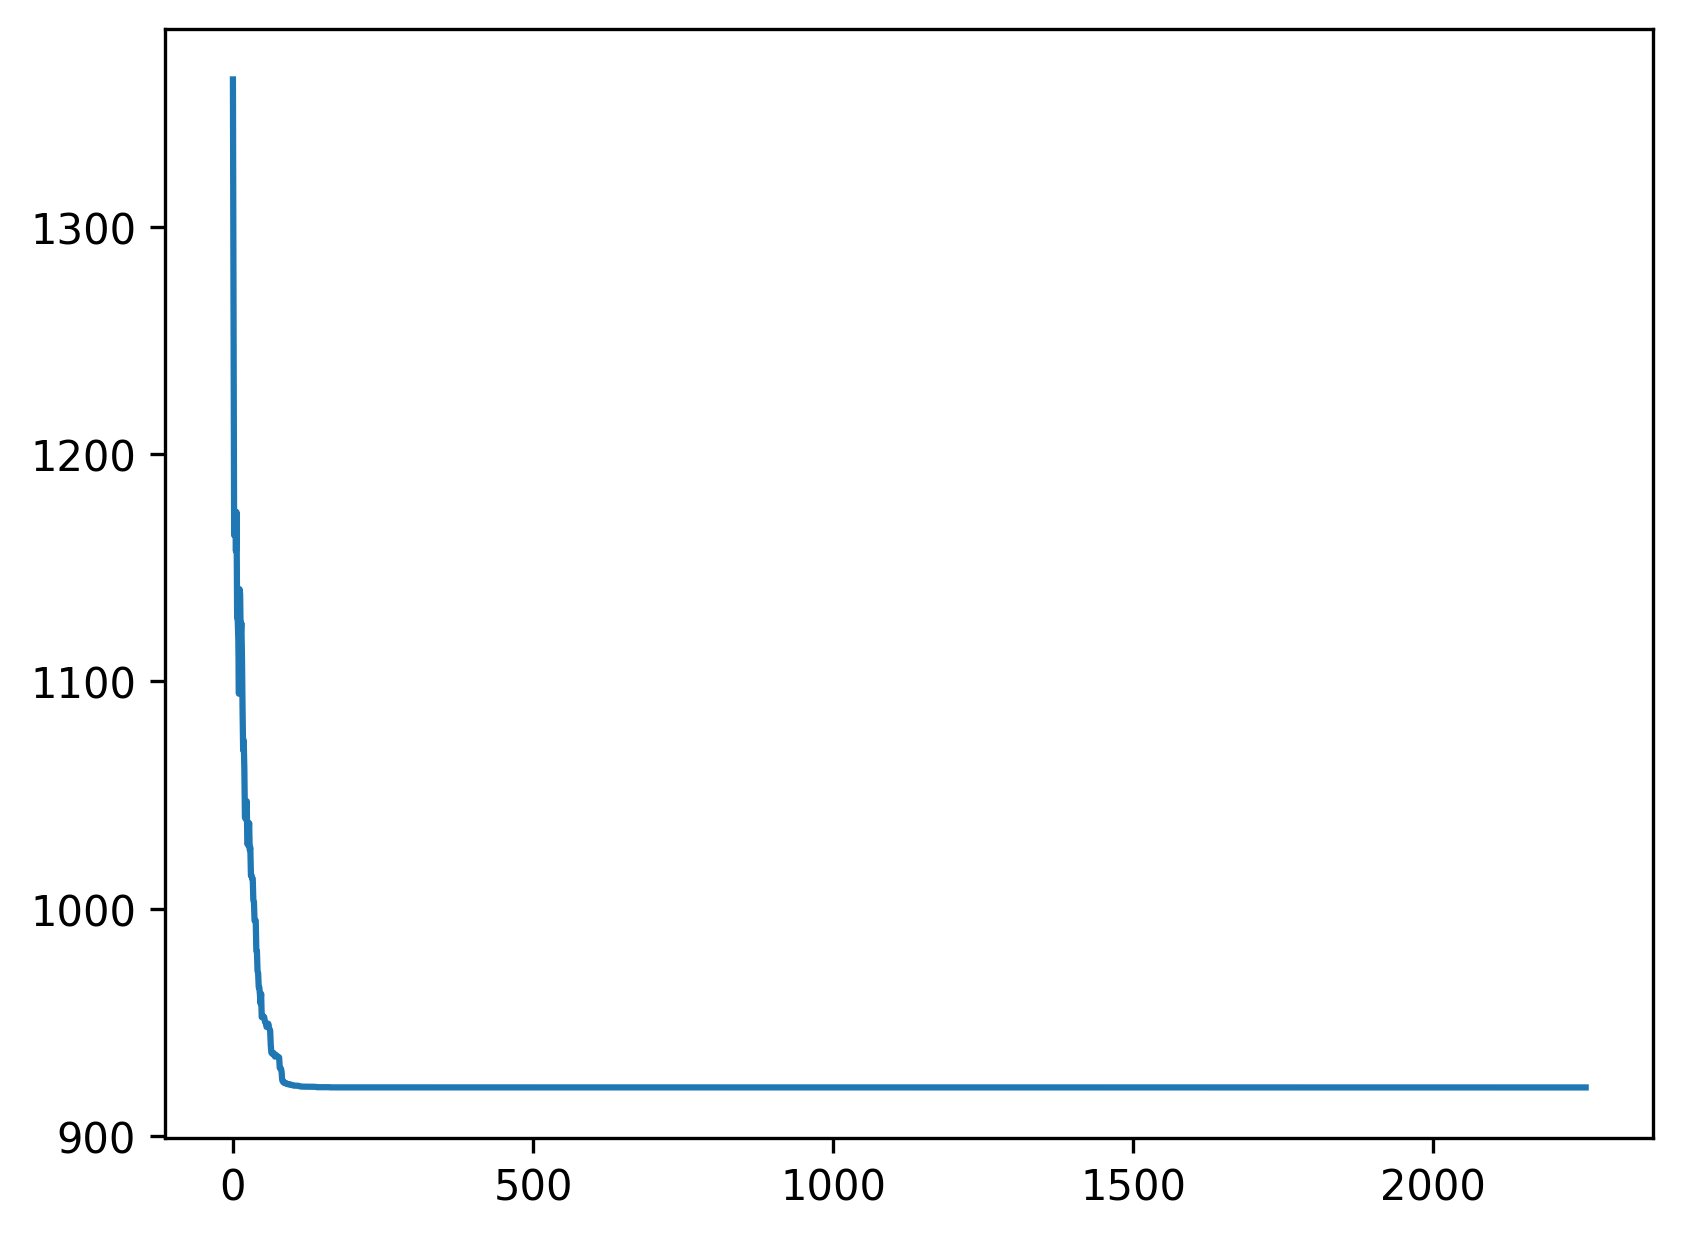

In [186]:
plot_hypervolume(lemoo._generation_history, ref_point=nadir)

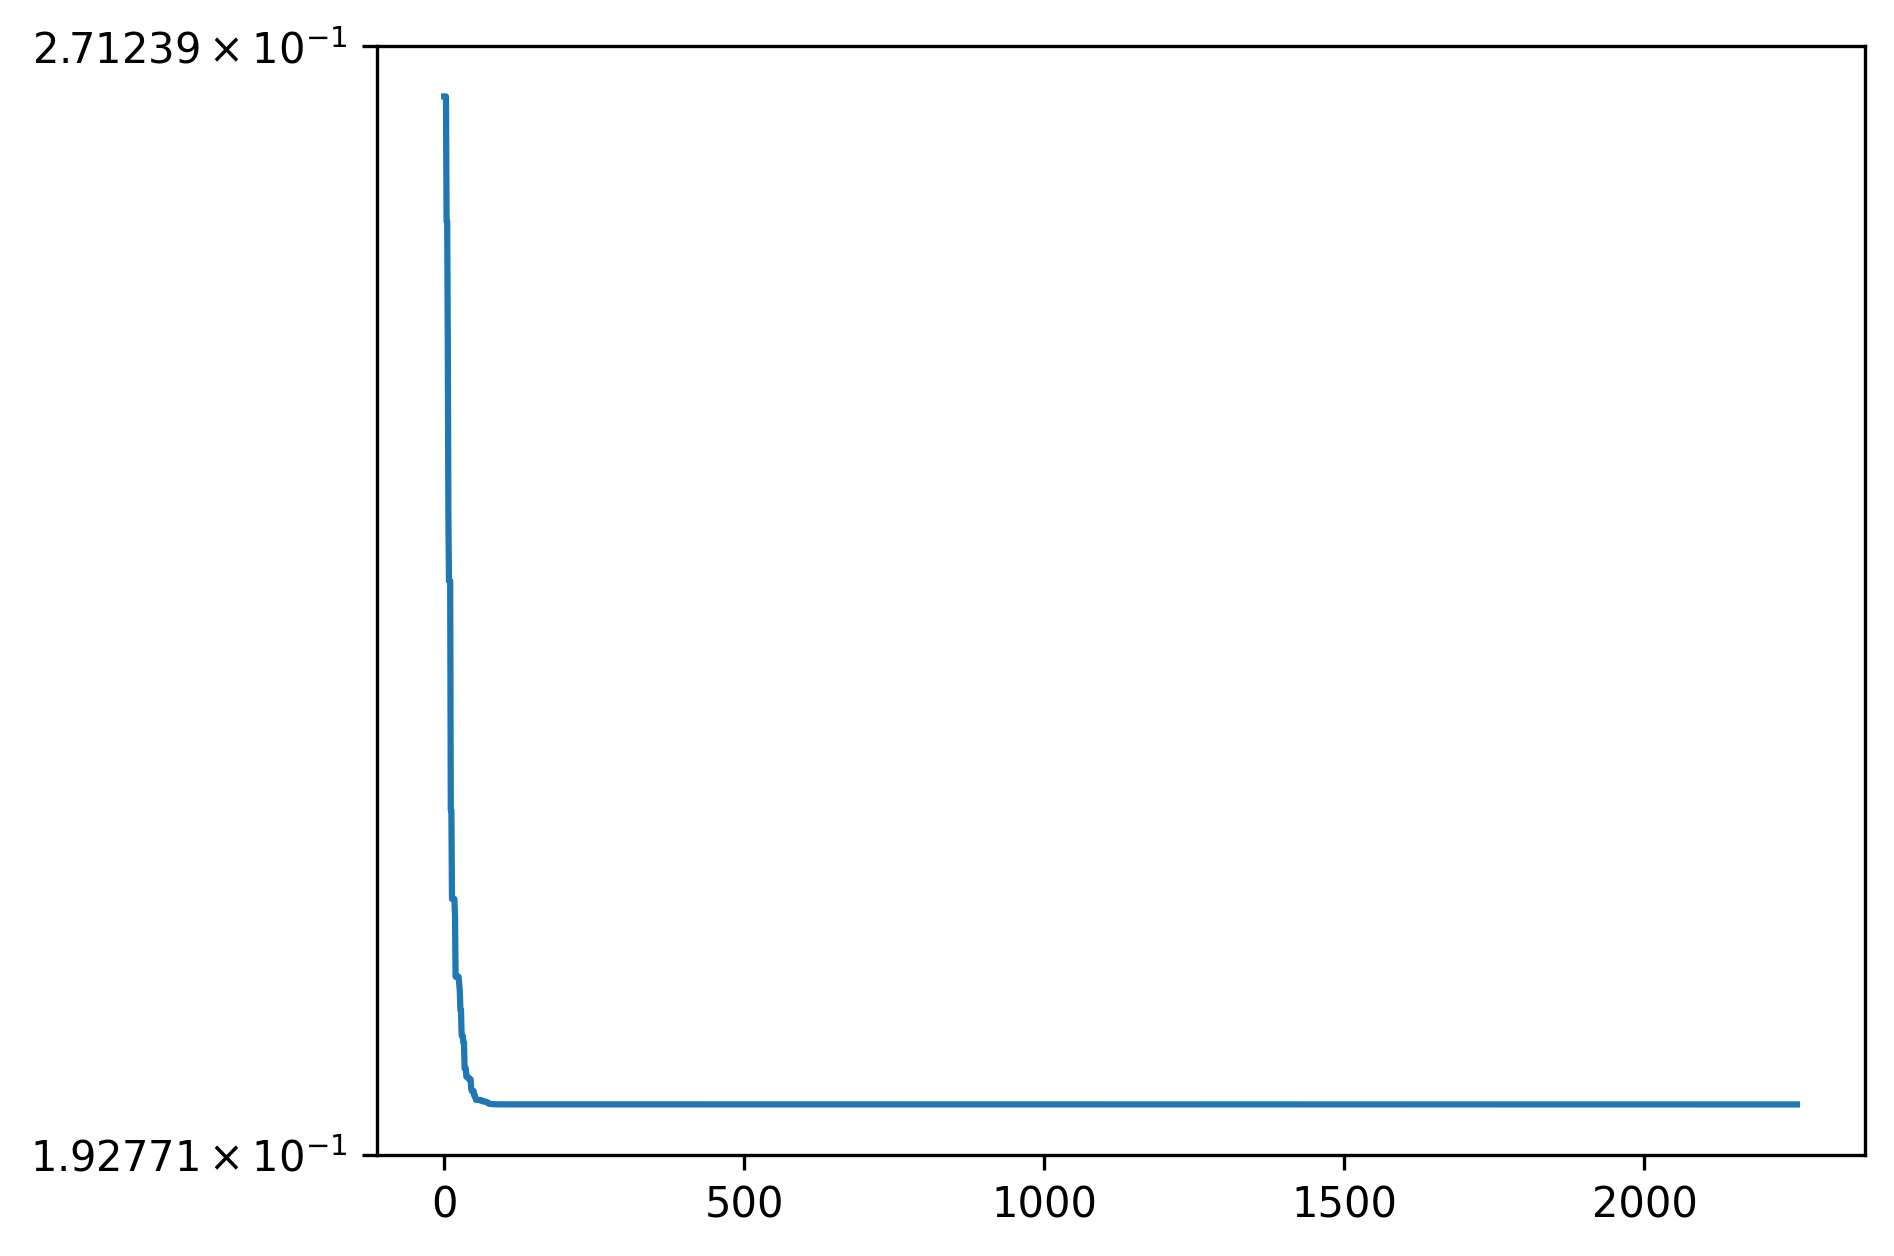

In [187]:
plot_best_fitnesses(lemoo._generation_history, ylog=True)

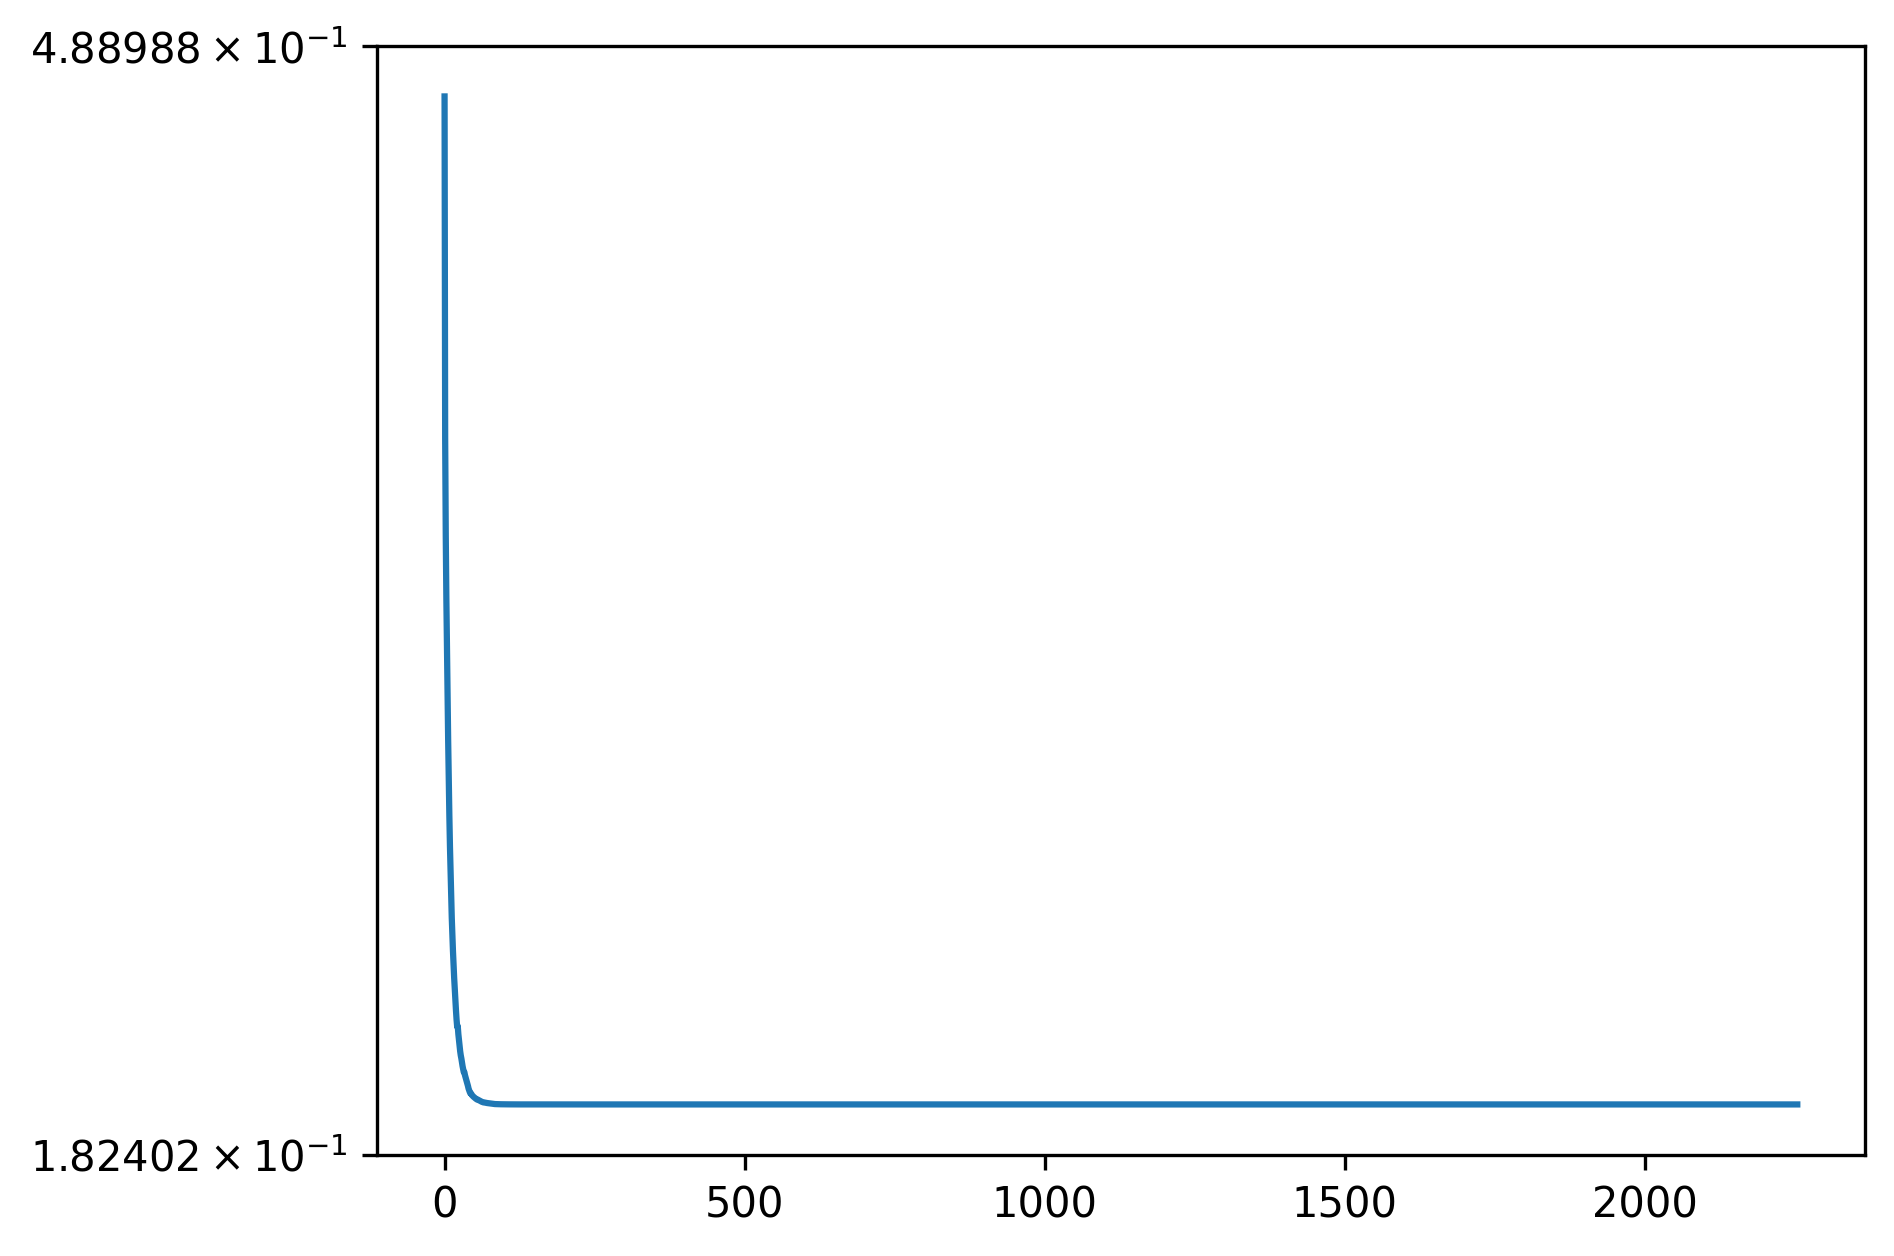

In [188]:
plot_mean_fitnesses(lemoo._generation_history, ylog=True)

SkopeRulesClassifier(bootstrap=True, bootstrap_features=True, max_depth=None,
                     max_features=None, n_estimators=30, precision_min=0.1)


AttributeError: 'SkopeRulesClassifier' object has no attribute 'tree_'

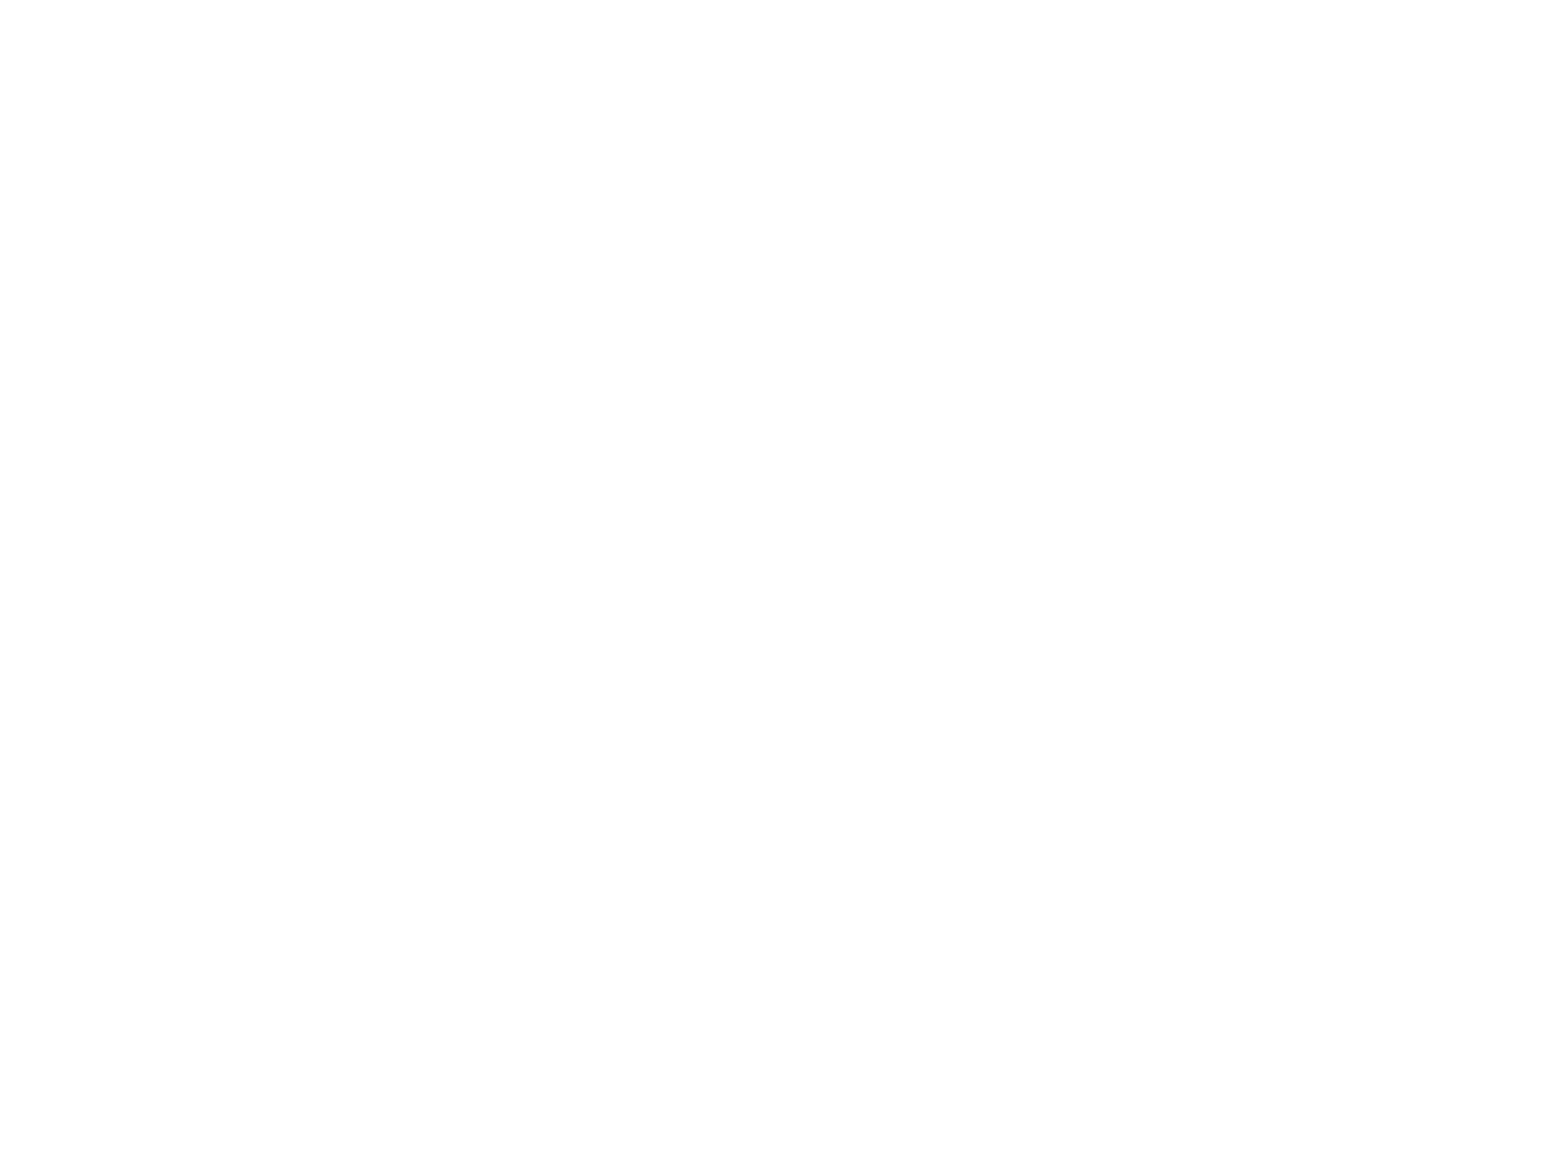

In [47]:
print(lemoo.current_ml_model)
tree.plot_tree(lemoo.current_ml_model)

In [28]:
print(problem.evaluate(lemoo._generation_history[-1].individuals[0]).objectives)
print(lower_limits)
print(upper_limits)

[[19.59251938  4.37805098 12.91280638  0.16809473]]


NameError: name 'lower_limits' is not defined

In [192]:
print(ref_point)

problem.evaluate(lemoo._generation_history[-1].individuals[0]).objectives

[20.   3.5 11.   0.1]


array([[24.90830333,  3.89266445, 11.78528349,  5.1086775 ]])

In [190]:
# print(lemoo.current_ml_model.rules_[1])
show_rules(lemoo.current_ml_model.rules_)

Rule -> Accuracy:
X_1 > 0.69952 and X_5 > 1.19999 --> 0.7550693636379773
X_4 > 2.60901 and X_5 > 1.19999 --> 0.751758467698301
X_2 <= 0.58187 and X_5 > 1.19999 --> 0.7459366248035846
X_1 > 0.69952 and X_5 > 1.19998 --> 0.7190673290362938
X_4 > 2.60901 and X_5 > 1.19998 --> 0.7163076923076923
X_2 <= 0.58187 and X_5 > 1.19998 --> 0.7106425758375254
X_0 <= 0.50001 and X_1 > 0.69952 --> 0.6373100889908099
X_4 > 2.60901 --> 0.5653980930649499
X_2 <= 0.58187 --> 0.549073272778692
X_6 > 0.4 --> 0.5169788790208224


In [ ]:
#print(np.logical_and(lemoo._generation_history[-1].objectives_fitnesses <= upper_limits, lemoo._generation_history[-1].objectives_fitnesses >= lower_limits))
a = lemoo._generation_history[-1].objectives_fitnesses[0:3]

fitness_fun(np.atleast_2d(a))

In [ ]:
lemoo._generation_history[-2].individuals

In [ ]:
upper_limits

In [ ]:
a - lower_limits

In [ ]:
upper_limits - a

In [ ]:
lower = np.where(a - lower_limits > 0, 0, np.abs(a - lower_limits))
upper = np.where(upper_limits - a > 0, 0, np.abs(upper_limits - a))

In [ ]:
lower

In [ ]:
upper

In [ ]:
lower + upper

In [ ]:
np.sum(lower + upper, axis=1).T

In [ ]:
fitness_fun(a)